# segmentation map으로 도로 이미지 만들기

1. 데이터에 한 가지 이상의 augmentation 방법을 적용
2. U-Net Generator를 사용
3. 모델 학습 후, 학습된 Generator를 이용해 테스트. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화.
5. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남기기. 

In [2]:
import numpy
import tensorflow as tf

In [ ]:
'''
$ wget zip파일_url링크
$ ln -s ~/cityscapes.zip ~/aiffel/workspace/conditional_generation/data
$ cd ~/aiffel/workspace/conditional_generation/data && unzip cityscapes.zip
'''

In [3]:
import os 

pathdir = os.getenv('HOME')+'/aiffel/workspace/conditional_generation/data/'
train_path = os.path.join(pathdir, 'cityscapes/train/')
test_path = os.path.join(pathdir, 'cityscapes/val/')

In [4]:
print("number of train examples :", len(os.listdir(train_path)))

number of train examples : 1000


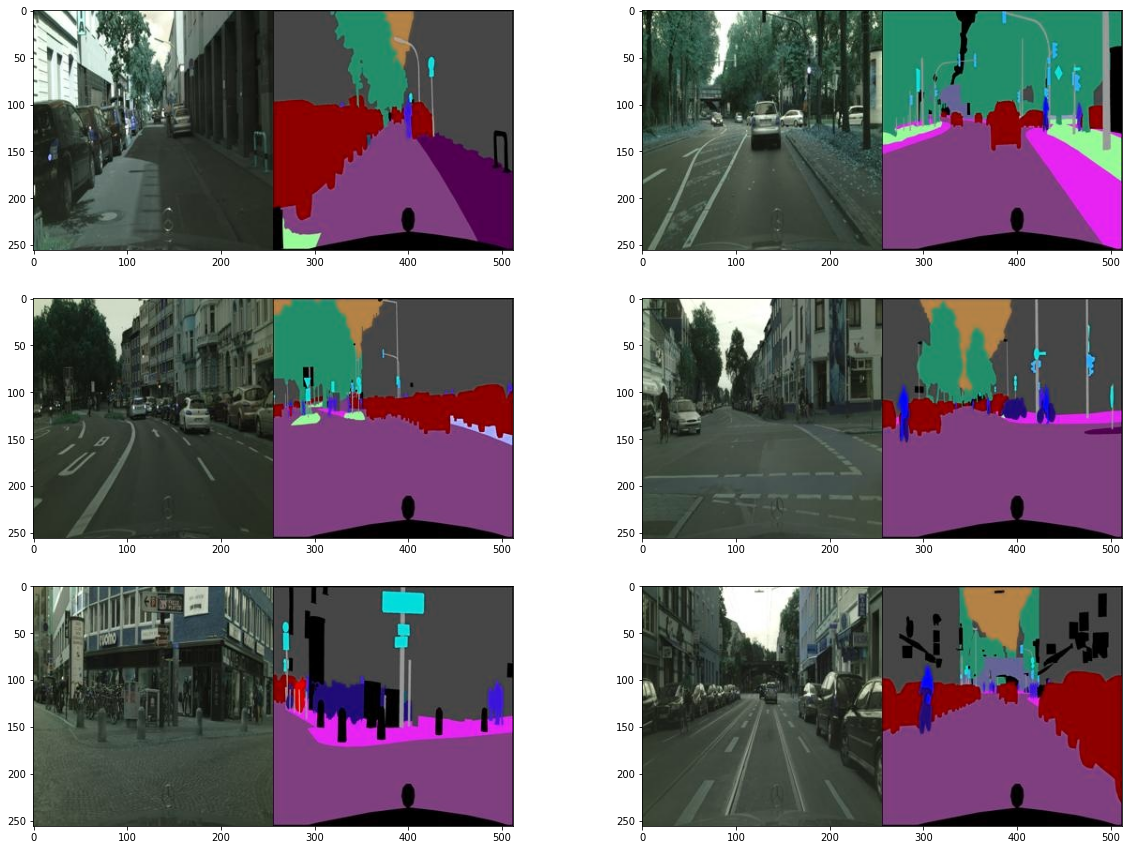

In [5]:
# train data 중 6개 시각화

import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_path + os.listdir(train_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [6]:
f = train_path + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

#이미지 데이터의 크기는 256,512,3 

(256, 512, 3)


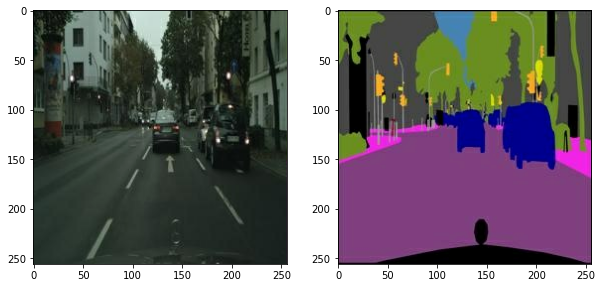

In [7]:
#데이터를 반으로 나눠주어(분할) 데이터 셋을 구성한다.

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    #왼쪽 그림은 ground_truth(gt), 오른쪽 그림은 segmetation(seg)
    w = tf.shape(img)[1] // 2
    gt = img[:, :w, :] 
    gt = tf.cast(gt, tf.float32)
    seg = img[:, w:, :] 
    seg = tf.cast(seg, tf.float32)
    return normalize(gt), normalize(seg)

f = train_path + os.listdir(train_path)[3]
gt, seg = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(gt))
plt.subplot(1,2,2); plt.imshow(denormalize(seg))

In [8]:
#나눈 이미지를 기준으로 data augmentation 적용하기

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용 
def apply_augmentation(gt, seg):
    stacked = tf.concat([gt, seg], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

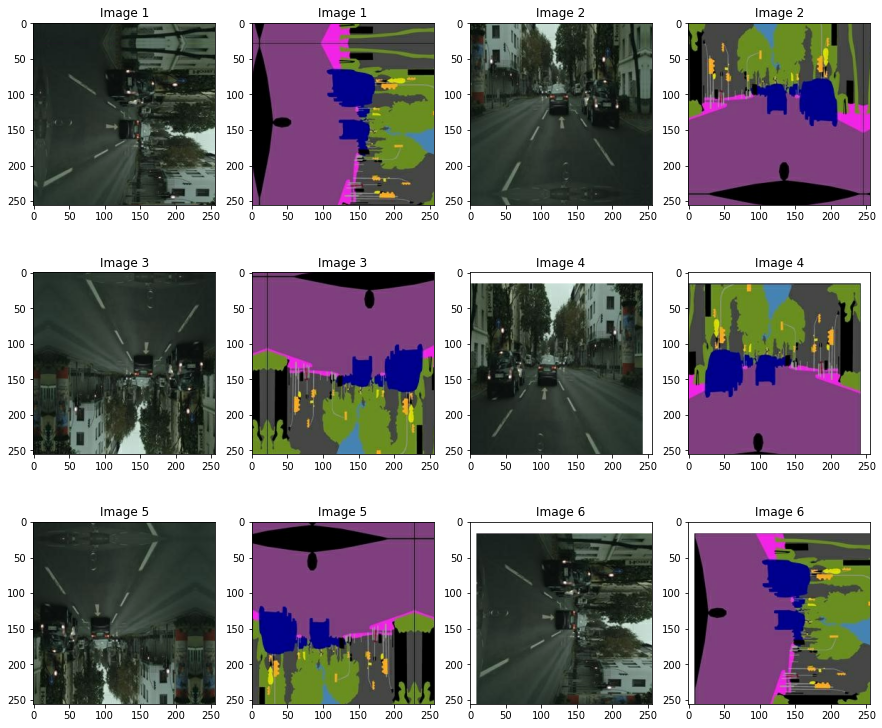

In [9]:
# augmetation data 시각화

plt.figure(figsize=(15,13))
img_n = 1

#이미지 개수 6개 (각각 gt, seg 1개씩 총 12장)
for i in range(1, 13, 2):
    augmented_gt, augmented_seg = apply_augmentation(gt, seg)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_gt)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    img_n += 1

In [30]:
#데이터 load + augmenation
from tensorflow import data

def get_train(img_path):
    gt, seg = load_img(img_path)
    gt, seg = apply_augmentation(gt, seg)
    return gt, seg

train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

## generator의 encode - decode subclassing

In [12]:
#encode

from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()



In [13]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        self.blocks = []
        for i, f in enumerate(filters):
            if i <= 2:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout = False))
        self.blocks.append(layers.Conv2DTranspose(3,4,2,"same", use_bias = False))
        
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [20]:
Encoder().get_summary

<bound method Encoder.get_summary of <__main__.Encoder object at 0x7f65c13168e0>>

In [18]:
Decoder().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block_14 (DecodeBlock (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_15 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_16 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_17 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_18 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_19 (DecodeBlock (None, 64, 64, 128)       5248

In [22]:
# encoder 와 decoder를 연결하여 generator 구성하기 (u-net 구조)

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        #encoder 마지막 출력 제외
        features = features[:-1]
        
        #대칭적 구조를 위한 feature 역순 concatenate
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [23]:
UNetGenerator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_5[0][0]                    
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

## discriminator의 encode - decode subclassing

In [24]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]

        for i, f in enumerate(filters):
            self.blocks.append(DiscBlock(n_filters=f,
            stride=2 if i<3 else 1,
            custom_pad=False if i<3 else True,
            use_bn=False if i==0 and i==4 else True,
            act=True if i<4 else False))

        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")

    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [25]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block_5 (DiscBlock)        (None, 128, 128, 64) 6144        concatenate_8[0][0]        

## 학습 및 테스트

In [26]:
#loss function 정의

from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

#optimizer 정의
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [32]:
#train function

@tf.function
def train_step(gt, seg):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(gt, training=True)
        # Discriminator 예측
        fake_disc = discriminator(gt, fake_colored, training=True)
        real_disc = discriminator(gt, seg, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, seg, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
        
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [33]:
#epoch 10으로 iter 10마다 로그를 기록(gene_loss, L! loss, dis_loss)

EPOCHS = 10
generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (gt, seg) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(gt, seg)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9079                     
L1_loss:0.3673                     
Discriminator_loss:1.2760

EPOCH[1] - STEP[20]                     
Generator_loss:1.2321                     
L1_loss:0.3028                     
Discriminator_loss:1.0845

EPOCH[1] - STEP[30]                     
Generator_loss:1.3590                     
L1_loss:0.2769                     
Discriminator_loss:0.9955

EPOCH[1] - STEP[40]                     
Generator_loss:1.7174                     
L1_loss:0.2336                     
Discriminator_loss:0.7092

EPOCH[1] - STEP[50]                     
Generator_loss:2.2091                     
L1_loss:0.2469                     
Discriminator_loss:0.8496

EPOCH[1] - STEP[60]                     
Generator_loss:1.6985                     
L1_loss:0.2366                     
Discriminator_loss:0.7973

EPOCH[1] - STEP[70]                     
Generator_loss:1.3544                     
L1_loss:0.2421                    

EPOCH[3] - STEP[70]                     
Generator_loss:3.0913                     
L1_loss:0.2546                     
Discriminator_loss:0.4652

EPOCH[3] - STEP[80]                     
Generator_loss:2.2410                     
L1_loss:0.1822                     
Discriminator_loss:0.4961

EPOCH[3] - STEP[90]                     
Generator_loss:2.1405                     
L1_loss:0.1679                     
Discriminator_loss:2.7884

EPOCH[3] - STEP[100]                     
Generator_loss:1.9244                     
L1_loss:0.2201                     
Discriminator_loss:1.0022

EPOCH[3] - STEP[110]                     
Generator_loss:1.7794                     
L1_loss:0.1832                     
Discriminator_loss:0.8039

EPOCH[3] - STEP[120]                     
Generator_loss:1.5424                     
L1_loss:0.1856                     
Discriminator_loss:0.8281

EPOCH[3] - STEP[130]                     
Generator_loss:1.7940                     
L1_loss:0.2038                

EPOCH[5] - STEP[130]                     
Generator_loss:1.0929                     
L1_loss:0.2189                     
Discriminator_loss:0.5965

EPOCH[5] - STEP[140]                     
Generator_loss:1.9741                     
L1_loss:0.2137                     
Discriminator_loss:0.7490

EPOCH[5] - STEP[150]                     
Generator_loss:1.7146                     
L1_loss:0.1753                     
Discriminator_loss:0.7918

EPOCH[5] - STEP[160]                     
Generator_loss:2.9929                     
L1_loss:0.1652                     
Discriminator_loss:1.8743

EPOCH[5] - STEP[170]                     
Generator_loss:1.1698                     
L1_loss:0.1805                     
Discriminator_loss:0.7513

EPOCH[5] - STEP[180]                     
Generator_loss:0.8827                     
L1_loss:0.2028                     
Discriminator_loss:0.8407

EPOCH[5] - STEP[190]                     
Generator_loss:0.1813                     
L1_loss:0.1933             

EPOCH[7] - STEP[190]                     
Generator_loss:2.3145                     
L1_loss:0.2255                     
Discriminator_loss:0.3152

EPOCH[7] - STEP[200]                     
Generator_loss:0.3340                     
L1_loss:0.1793                     
Discriminator_loss:1.4725

EPOCH[7] - STEP[210]                     
Generator_loss:3.4924                     
L1_loss:0.1675                     
Discriminator_loss:2.7192

EPOCH[7] - STEP[220]                     
Generator_loss:1.3711                     
L1_loss:0.1447                     
Discriminator_loss:0.7262

EPOCH[7] - STEP[230]                     
Generator_loss:3.7199                     
L1_loss:0.1863                     
Discriminator_loss:1.1258

EPOCH[7] - STEP[240]                     
Generator_loss:2.7733                     
L1_loss:0.1838                     
Discriminator_loss:0.6087

EPOCH[7] - STEP[250]                     
Generator_loss:1.5732                     
L1_loss:0.1674             

EPOCH[9] - STEP[250]                     
Generator_loss:1.6794                     
L1_loss:0.1677                     
Discriminator_loss:0.8743

EPOCH[10] - STEP[10]                     
Generator_loss:1.0411                     
L1_loss:0.1443                     
Discriminator_loss:1.3037

EPOCH[10] - STEP[20]                     
Generator_loss:0.6100                     
L1_loss:0.1929                     
Discriminator_loss:1.0096

EPOCH[10] - STEP[30]                     
Generator_loss:2.6120                     
L1_loss:0.1699                     
Discriminator_loss:0.6429

EPOCH[10] - STEP[40]                     
Generator_loss:1.8442                     
L1_loss:0.1642                     
Discriminator_loss:0.5266

EPOCH[10] - STEP[50]                     
Generator_loss:1.9888                     
L1_loss:0.2286                     
Discriminator_loss:0.5348

EPOCH[10] - STEP[60]                     
Generator_loss:1.0051                     
L1_loss:0.1766             

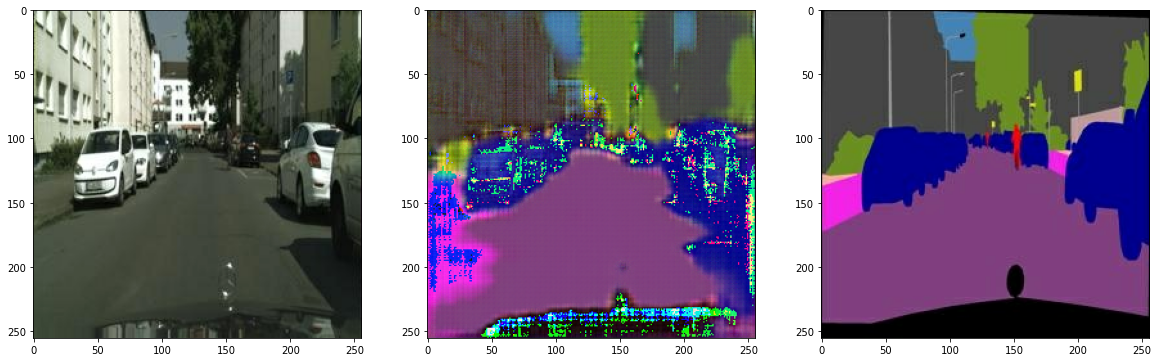

In [37]:
#test set 2번째 사진 색칠하기

test_ind = 1
#test dataset

f = test_path + os.listdir(test_path)[test_ind]
gt, seg = load_img(f)

pred = generator(tf.expand_dims(gt, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(gt))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(seg))

In [45]:
def show_test(path, generator):
    for i in range(len(os.listdir(path))):
        f = path + os.listdir(path)[i]
        gt, seg = load_img(f)
        pred = generator(tf.expand_dims(gt, 0))
        pred = denormalize(pred)
        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1); plt.imshow(denormalize(gt)); plt.title('real Image', fontsize=20)
        plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('colored Image', fontsize=20)
        plt.subplot(1,3,3); plt.imshow(denormalize(seg)); plt.title('real-colored Image', fontsize=20)

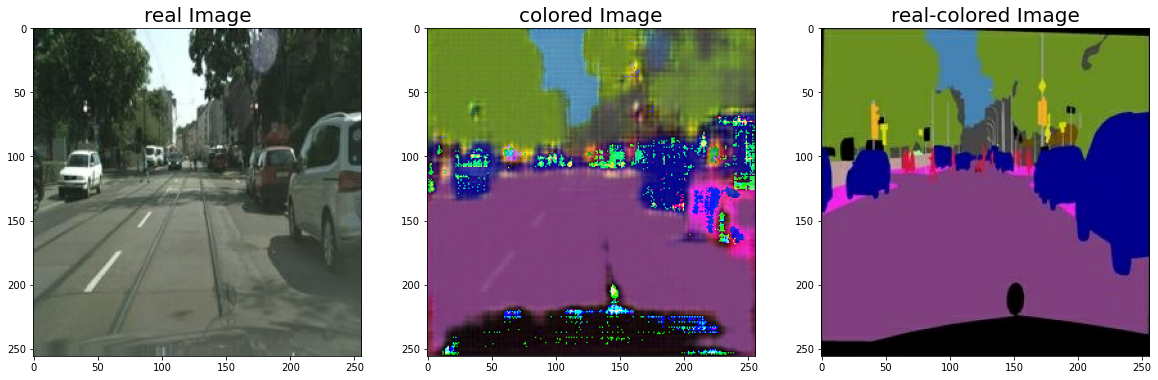

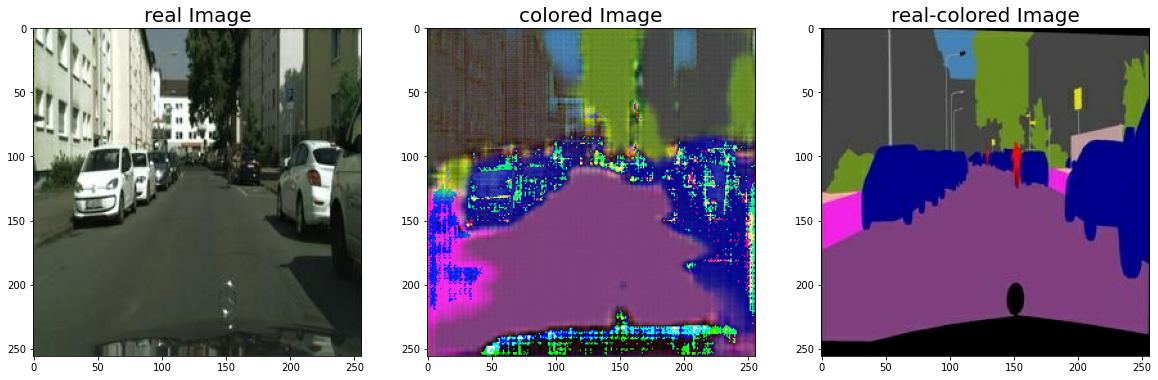

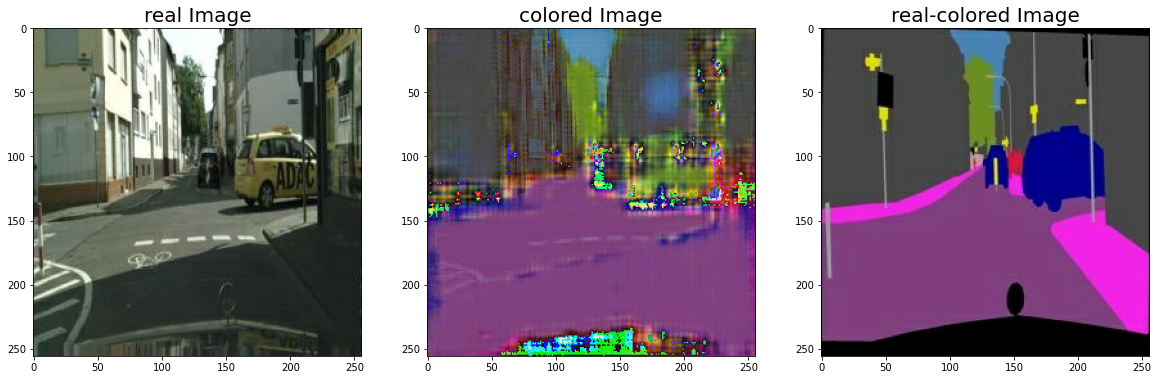

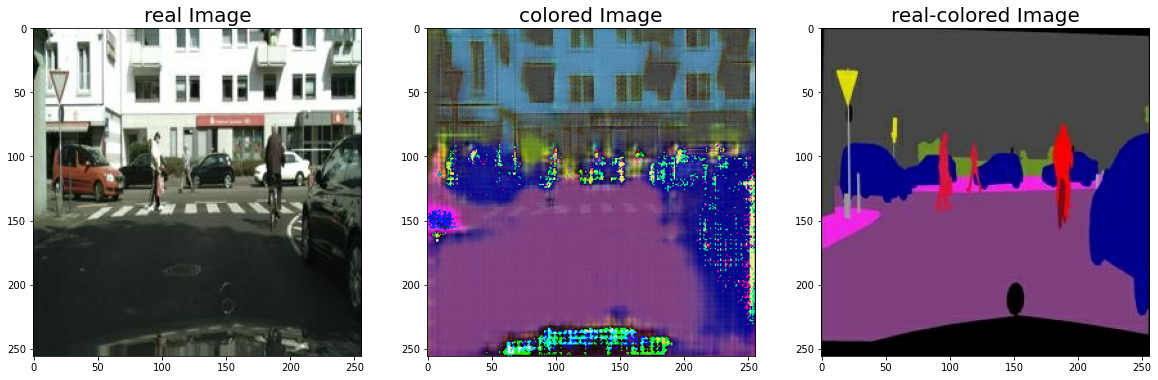

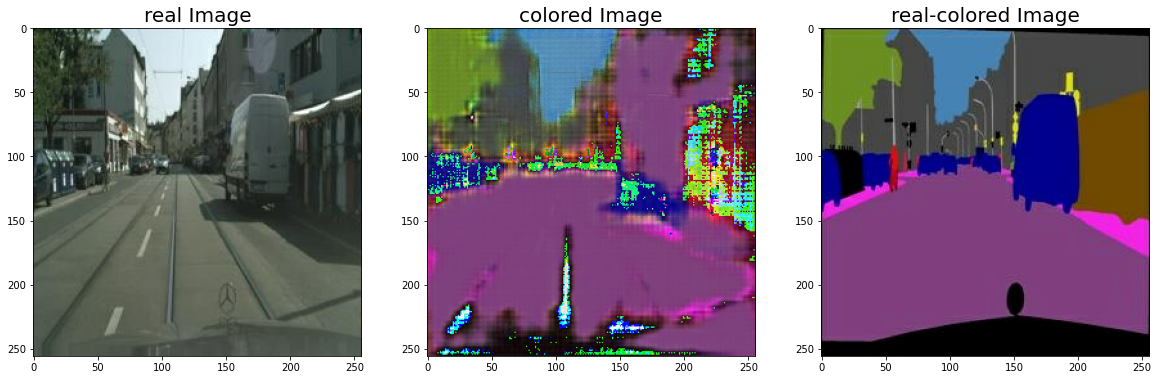

In [46]:
show_test(test_path, generator)

## 회고하기

1. generator가 예상한 그림은 원본에 이미 색칠이 되어 있어 더욱 불안정하게 나오는 것 같아 이를 해결할 방법을 모색할 필요가 있다고 생각한다.  
ex) 실제 사진을 sketch화 한 사진(AI가 예측한)을 input으로 넣기
2. 하드웨어 리소스가 충분하다면 epoch를 늘려 loss모니터링 하면서 최적의 모델을 도출해보고 싶다.
3. L! + cGAN의 손실 함수에 대해 보다 자세히 이해할 시간이 필요하다.